In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

import wide_resnet_submodule.config as cf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from wide_resnet_submodule.networks import *
from utils.graphs_config import ABC_3, edges2topology, adj2edges
from utils.functions import fit_batch_cifar, update_params_cifar, calc_accuracy_cifar, get_cumulative_train_loss

In [2]:
topology = edges2topology(adj2edges(ABC_3))
n_agents = len(topology)
pprint(topology)

defaultdict(<class 'dict'>,
            {'Alice': {'Alice': 0.33333333333234094,
                       'Bob': 0.3333333333271214,
                       'Charlie': 0.3333333333405377},
             'Bob': {'Alice': 0.3333333333271214,
                     'Bob': 0.3333333333296149,
                     'Charlie': 0.33333333334326365},
             'Charlie': {'Alice': 0.3333333333405377,
                         'Bob': 0.33333333334326365,
                         'Charlie': 0.33333333331619863}})


In [3]:
model_name = 'lenet'
num_classes = 10

if model_name == 'lenet':
    model = LeNet
    model_args = [num_classes]
elif model_name == 'vggnet':
    model = VGG
    model_args = [11, num_classes] # VGGnet depth should be either 11, 13, 16, 19
elif model_name == 'resnet':
    model = ResNet
    model_args = [18, num_classes] # Resnet depth should be either 18, 34, 50, 101, 152
elif model_name == 'wide-resnet':
    model = Wide_ResNet
    model_args = [16, 10, 0.3, num_classes] # depth, widen_factor, dropout (Wide-resnet depth should be 6n+4)
else:
    print('Error: Network should be either [LeNet / VGGNet / ResNet / Wide_ResNet', file=sys.stderr)
    exit(0)

criterion = nn.CrossEntropyLoss
learning_rate = 0.02

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}

In [4]:
# Hyper Parameter settings
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

In [5]:
dataset_name = 'cifar10'

In [6]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    indices = [i for i in range(len(trainset))]
    np.random.shuffle(indices)
    indices = indices[:n_agents*(len(trainset) // n_agents)]
    indices = np.array_split(indices, n_agents)
    subsets = [torch.utils.data.Subset(trainset, indices=ind) for ind in indices]
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

elif dataset_name == 'titanic':
    def prepare_dataset(df):
        df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
        df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
        df = df.fillna({'Age': df['Age'].mean()})
        df['Age'] /= 100
        df['Fare'] /= 100
        df['_bias'] = 1
        if 'Survived' in df.columns:
            return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
        else:
            return df
    
    train_data = pd.read_csv('../data/titanic/train.csv')
    train_features, train_answers = prepare_dataset(train_data)

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
    X = train_features[features].to_numpy()
    y = train_answers.to_numpy()

    common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
    X_train, y_train = X[X.shape[0] // 10:], y[X.shape[0] // 10:]
    
    X_train_parts = np.array_split(X_train, n_agents)
    y_train_parts = np.array_split(y_train, n_agents)
    
    train_loaders = {node_name: [(x, y)] for node_name, x, y in zip(topology, X_train_parts, y_train_parts)}
    test_loader = (common_test_X, common_test_y)
else:
    print("This dataset is not yet supported.")
    exit(0)

Files already downloaded and verified


In [7]:
num_epochs = 5

In [8]:
epoch_len = min(len(tl) for tl in train_loaders.values())
print(epoch_len)

131


In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Yes, we use CUDA!")
else:
    print("CUDA is not available. Check your drivers.")

CUDA is not available. Check your drivers.


In [10]:
stat_funcs = {'test_accuracy': calc_accuracy_cifar, 'cumulative_train_loss': get_cumulative_train_loss}
statistics = {func_name: {node_name: {'values': [], 'iters': [], 'tmp': 0.0} 
                          for node_name in topology}
              for func_name in stat_funcs}

In [11]:
session_name = 'ABC_3'

In [12]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    fit_step=fit_batch_cifar, # function(node: ConsensusNode, epoch: Int)
                    update_params=update_params_cifar, # function(node: ConsensusNode)
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    update_params_epoch_start=3, # the first epoch from which consensus begins
                    update_params_period=1, # consensus iteration period
                    use_cuda=use_cuda,
                    resume_path=f'./checkpoint/{dataset_name}/{session_name}', # None if first try
                    session=f'{dataset_name}/{session_name}',
                    verbose=3 # verbose mode
                   )

In [13]:
master.set_model(model, *model_args)

Master set model=<class 'wide_resnet_submodule.networks.lenet.LeNet'>, args=(10,), kwargs={}


In [14]:
master.set_optimizer(optimizer, optimizer_kwargs)

Master set optimizer=<class 'torch.optim.sgd.SGD'>, args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}


In [15]:
master.set_error(criterion)

Master set error=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, args=(), kwargs={}


In [16]:
master.set_stats(stat_funcs=stat_funcs, statistics=statistics)

Master successfully loads stat_funcs=dict_keys(['test_accuracy', 'cumulative_train_loss']) from ./checkpoint/cifar10/ABC_3
Master successfully loads statistics=dict_keys(['test_accuracy', 'cumulative_train_loss']) from ./checkpoint/cifar10/ABC_3


In [17]:
# init consensus nodes
master.initialize_nodes()

Node Alice successfully loads the model LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) from ./checkpoint/cifar10/ABC_3/Alice.t7.
Node Alice set optimizer=<class 'torch.optim.sgd.SGD'> with args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}
Node Alice set error=CrossEntropyLoss() with args=(), kwargs={}
Node Bob successfully loads the model LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) from ./checkpoint/cifar10/ABC_3/Bob.t7.
Node Bob set optimizer=<class 'to

In [18]:
# for pretty outputs uncomment (if warnings)
# import warnings
# warnings.simplefilter(action='ignore', category=Warning)

In [19]:
master.start_consensus()
print('Done!')

Master started



Epoch 41:
Node Alice: epoch 41, test_accuracy= 52.01
Node Alice: epoch 41, cumulative_train_loss= 1.35
Node Bob: epoch 41, test_accuracy= 52.96
Node Bob: epoch 41, cumulative_train_loss= 1.35
Node Charlie: epoch 41, test_accuracy= 52.91
Node Charlie: epoch 41, cumulative_train_loss= 1.36
Saving stats...
Saving models...
Epoch 41 ended in 23.90 sec

Epoch 42:
Node Alice: epoch 42, test_accuracy= 52.68
Node Alice: epoch 42, cumulative_train_loss= 1.34
Node Bob: epoch 42, test_accuracy= 53.27
Node Bob: epoch 42, cumulative_train_loss= 1.33
Node Charlie: epoch 42, test_accuracy= 53.72
Node Charlie: epoch 42, cumulative_train_loss= 1.34
Saving stats...
Saving models...
Epoch 42 ended in 11.06 sec

Epoch 43:
Node Alice: epoch 43, test_accuracy= 53.02
Node Alice: epoch 43, cumulative_train_loss= 1.33
Node Bob: epoch 43, test_accuracy= 53.52
Node Bob: epoch 43, cumulative_train_loss= 1.32
Node Charlie: epoch 43, test_accuracy= 53.84
Node Charlie: epoch 43, cumulative_train_loss= 1.32
Saving st

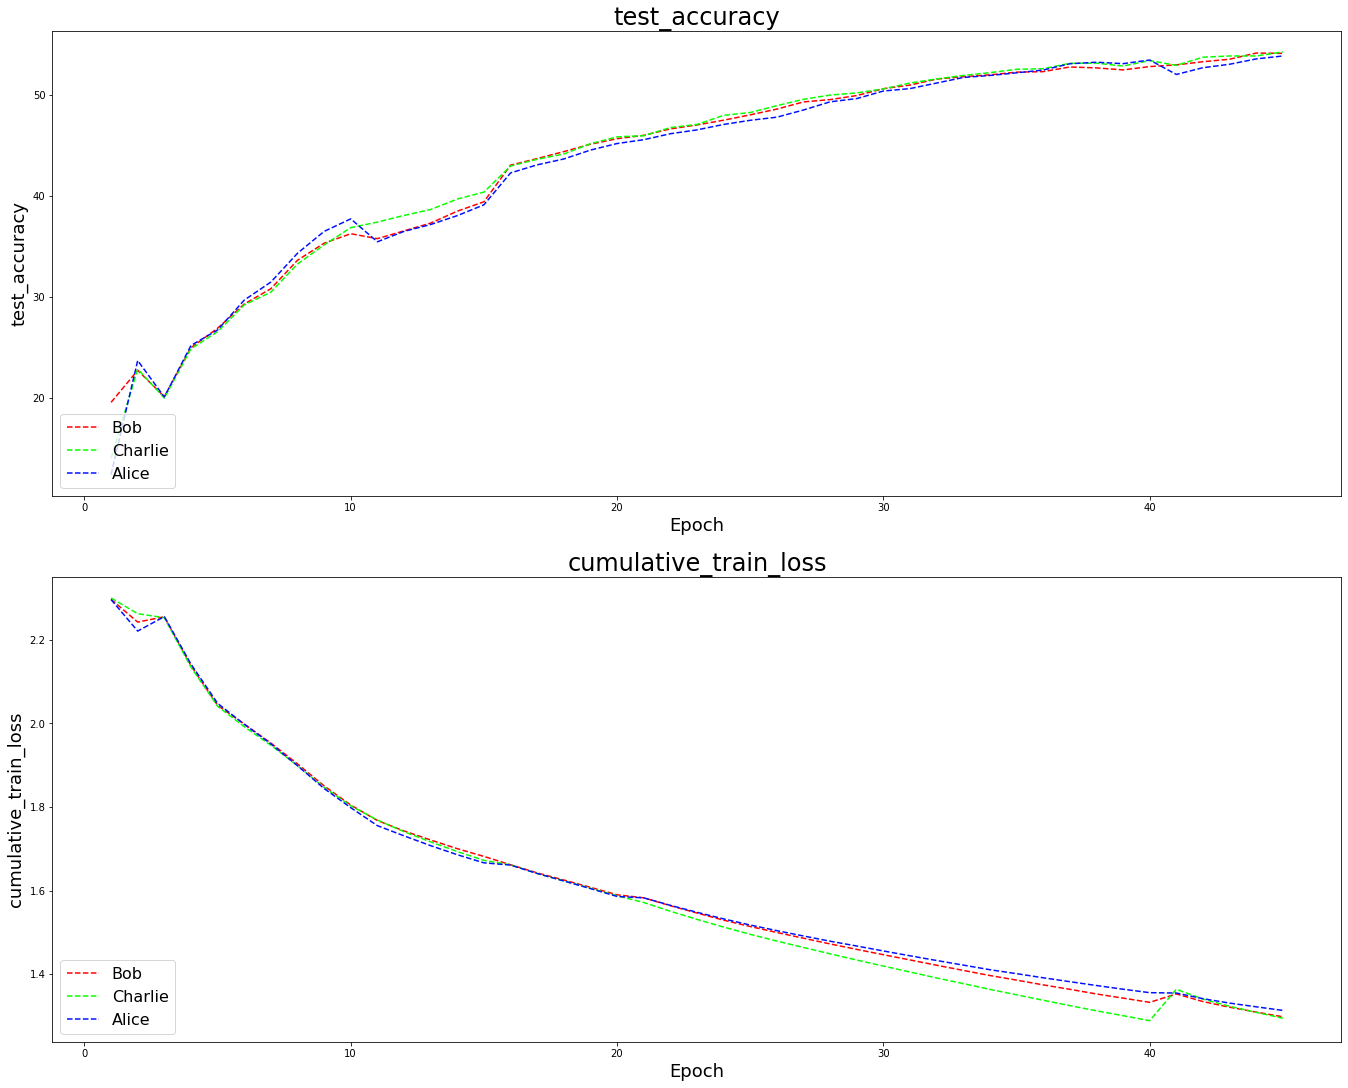

In [20]:
def get_cmap(n, name='hsv'):
    '''
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    '''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(n_agents + 1)

fig, axs = plt.subplots(len(statistics), 1, figsize=(20, 16))
fig.tight_layout(pad=6.0)

for i, (func_name, node_stat) in enumerate(master.statistics.items()):
    axs[i].set_title(func_name, fontsize=24)
    axs[i].set_xlabel('Epoch', fontsize=18)
    axs[i].set_ylabel(func_name, fontsize=18)
    for j, (node_name, stat) in enumerate(node_stat.items()):
        axs[i].plot(stat['epoch'], stat['values'], label=node_name, linestyle='--', color=cmap(j))
    axs[i].legend(loc=3, fontsize=16)
plt.show()